# Quantenzählen

Um diesen Algorithmus zu verstehen, ist es wichtig, dass du zuerst sowohl den Grover-Algorithmus als auch den Quantenphasenschätzungsalgorithmus (Quantum Phase Estimation) verstehst. Während Grovers Algorithmus versucht, eine Lösung für das Orakel zu finden, sagt uns der Quantenzählalgorithmus (Quantum Counting), wie viele dieser Lösungen es gibt. Dieser Algorithmus ist interessant, da er sowohl Quantensuche (Quantum Search) als auch Quantenphasenschätzung kombiniert.

## 1. Übersicht<a id="overview"></a>

### 1.1 Intuition<a id="intuition"></a>

Beim Quantenzählen verwenden wir einfach den Quantenphasenschätzungsalgorithmus, um einen Eigenwert einer Grover-Suchiteration zu finden. Du wirst dich erinnern, dass eine Iteration von Grovers Algorithmus, $G$, den Zustandsvektor um $\theta$ in der Basis von $|\omega\rangle$, $|s'\rangle$ dreht:![Bild1](images/quantum_counting1.svg)

Die prozentuale Anzahl der Lösungen in unserem Suchraum beeinflusst die Differenz zwischen $|s\rangle$ und $|s'\rangle$. Wenn es zum Beispiel nicht viele Lösungen gibt, wird $|s\rangle$ sehr nahe an $|s'\rangle$ liegen und $\theta$ wird sehr klein sein. Es stellt sich heraus, dass die Eigenwerte des Grover-Iterators $e^{\pm i\theta}$ sind, und wir können dies mithilfe der Quantenphasenschätzung (QPE) extrahieren, um die Anzahl der Lösungen ($M$) abzuschätzen.

### 1.2 Ein genauerer Blick<a id="closer_look"></a>

In der Basis von $|\omega\rangle$,$|s'\rangle$ können wir den Grover-Iterator als Matrix schreiben:

$$ G = \begin{pmatrix} \cos{\theta} &amp;&amp; -\sin{\theta}\ \sin{\theta} &amp;&amp; \cos{\theta} \end{pmatrix} $$

Die Matrix $G$ hat die Eigenvektoren:

$$ \begin{pmatrix} -i\ 1 \end{pmatrix} , \begin{pmatrix} i\ 1 \end{pmatrix} $$

Mit den oben genannten Eigenwerten $e^{\pm i\theta}$. Glücklicherweise müssen wir unser Register in keinem dieser Zustände vorbereiten, der Zustand $|s\rangle$ befindet sich in dem Raum, der von $|\omega\rangle$, $|s'\rangle$ aufgespannt wird, und ist somit eine Überlagerung der beiden Vektoren. $$ |s\rangle = \alpha |\omega\rangle + \beta|s'\rangle $$

Als Ergebnis ist die Ausgabe des QPE-Algorithmus eine Überlagerung der beiden Phasen, und wenn wir das Register messen, erhalten wir einen dieser beiden Werte! Wir können dann einfache Mathematik verwenden, um unsere Schätzung von $M$ zu erhalten.

![Bild2](images/quantum_counting2.svg)


## 2. Der Code<a id="code"></a>

### 2.1 Initialisierung unseres Codes<a id="init_code"></a>

Zuerst importieren wir alles, was wir brauchen:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, Aer

# import basic plot tools
from qiskit.visualization import plot_histogram

In dieser Anleitung entscheiden wir uns dafür, die ersten 4 Qubits auf unserer Schaltung zu „zählen“ (wir nennen die Anzahl der zählenden Qubits $t$, also $t = 4$) und die letzten 4 Qubits ($n = 4 $). In diesem Sinne können wir damit beginnen, die Bausteine unserer Schaltung zu erstellen.

### 2.2 Die Kontrollierte-Gover-Iteration<a id="cont_grover"></a>

Wir haben Grover-Iterationen bereits im Abschnitt über den Grover-Algorithmus behandelt. Hier verwenden wir die Schaltungsbibliothek, um schnell eine Schaltung zu erstellen, die eine Iteration von Grovers Algorithmus ausführt. Das Orakel, das wir verwenden, hat 5 Lösungen ($M = 5$) von 16 Zuständen ($N = 2^n = 16$).

In [2]:
def grover_operator(n_iterations):
    """Grover iteration circuit for oracle with 5/16 solutions
        Args:
            n_iterations (int): number of times to repeat the circuit
        Returns:
            Gate that implements n_iterations of the Grover operator
    """
    from qiskit.circuit.library import Diagonal, GroverOperator
    oracle = Diagonal([1,1,-1,1,1,1,1,-1,1,1,-1,-1,1,1,-1,1])
    grover_it = GroverOperator(oracle).repeat(n_iterations).to_gate()
    grover_it.label = f"Grover$^{n_iterations}$"
    return grover_it

Beachte, dass die Python-Funktion keine Eingaben entgegennimmt und ein `Gatter` Objekt mit 4 Qubits zurückgibt. Später auf dieser Seite verwenden wir die Methode `.control()` , um ein gesteuertes Gatter aus einem `Gatter` zu erstellen.

### 2.3 Die inverse QFT<a id="inv_qft"></a>

Wir müssen nun eine inverse QFT erstellen. Wir importieren dies aus der Schaltungsbibliothek und erstellen das Gatter mit t = 4 Qubits, da dies die Anzahl der Zähl-Qubits ist, die wir für unser Beispiel ausgewählt haben:

Beachte auch hier, dass wir uns entschieden haben, ein anderes `QuantumCircuit` Objekt zurückzugeben, damit wir das Gatter einfach umkehren können. Wir erstellen das Gatter mit t = 4 Qubits, da dies die Anzahl der Zähl-Qubits ist, die wir in dieser Anleitung ausgewählt haben:

In [3]:
from qiskit.circuit.library import QFT
qft_dagger = QFT(4, inverse=True).to_gate()
qft_dagger.label = "QFT†"

### 2.4 Alles zusammengesetzt<a id="putting_together"></a>

Wir haben jetzt alles, was wir brauchen, um unsere Schaltung zu vervollständigen! Fassen wir es zusammen.

Zuerst müssen wir alle Qubits in den Zustand $|+\rangle$ versetzen:

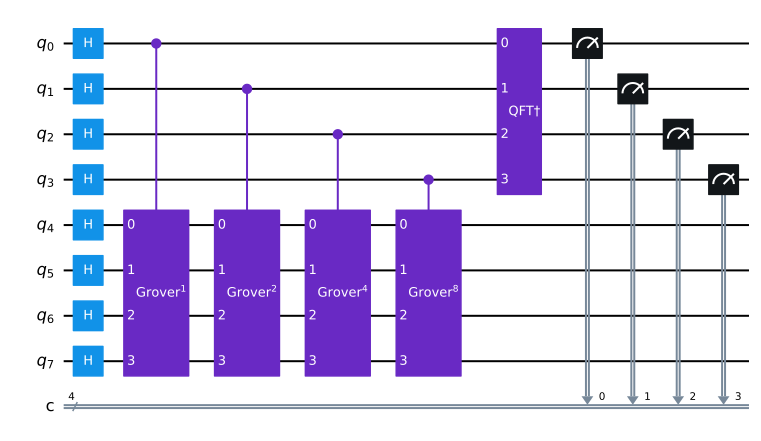

In [4]:
# Create QuantumCircuit
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t)))
    n_iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw(fold=-1)

Großartig! Sehen wir uns nun einige Ergebnisse an.

## 3. Simulieren<a id="simulating"></a>

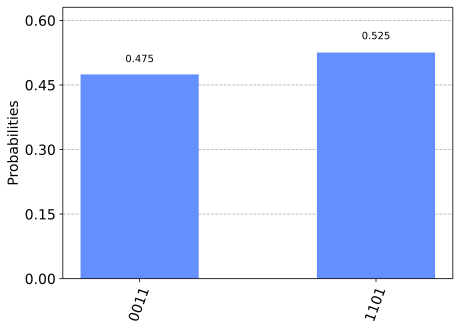

In [5]:
# Execute and see results
sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, sim)
job = sim.run(transpiled_qc)
hist = job.result().get_counts()
plot_histogram(hist)

Wir können zwei Werte hervorheben, die eine viel höhere Messwahrscheinlichkeit haben als die anderen. Diese beiden Werte entsprechen $e^{i\theta}$ und $e^{-i\theta}$, aber wir können die Anzahl der Lösungen noch nicht sehen. Wir brauchen etwas mehr Verarbeitung, um diese Informationen zu erhalten, also lass uns zuerst unsere Ausgabe in eine From bringen, mit der wir arbeiten können (ein `int` ).

Wir erhalten die Zeichenfolge des wahrscheinlichsten Ergebnisses aus unseren Ausgabedaten (obwohl beides ausreicht):

In [6]:
measured_str = max(hist, key=hist.get)

Lass uns dies nun als Ganzzahl speichern:

In [7]:
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)

Register Output = 13


## 4. Ermitteln der Anzahl der Lösungen (M)<a id="finding_m"></a>

Wir erstellen eine Funktion, `calculate_M()` , die als Eingabe die dezimale ganzzahlige Ausgabe unseres Registers, die Anzahl der Zähl-Qubits ($t$) und die Anzahl der Such-Qubits ($n$) verwendet.

Zuerst wollen wir $\theta$ von `measured_int` holen. Du wirst dich erinnern, dass QPE uns einen gemessenen $\text{value} = 2^n \phi$ aus dem Eigenwert $e^{2\pi i\phi}$ gibt, also müssen wir Folgendes tun, um $\theta$ zu erhalten:

$$ \theta = \text{value}\times\frac{2\pi}{2^t} $$

Oder im Code:

In [8]:
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 5.10509


Du erinnerst dich vielleicht, dass wir den Winkel $\theta/2$ aus dem inneren Produkt von $|s\rangle$ und $|s'\rangle$ erhalten können:

![Bild3](images/quantum_counting3.svg)

$$ \langle s'|s\rangle = \cos{\tfrac{\theta}{2}} $$

Und dieses $|s\rangle$ (eine einheitliche Überlagerung von Berechnungsbasiszuständen) kann in Form von $|\omega\rangle$ und $|s'\rangle$ geschrieben werden als:

$$ |s\rangle = \sqrt{\tfrac{M}{N}}|\omega\rangle + \sqrt{\tfrac{NM}{N}}|s'\rangle $$

Das Skalarprodukt von $|s\rangle$ und $|s'\rangle$ ist:

$$ \langle s'|s\rangle = \sqrt{\frac{NM}{N}} = \cos{\tfrac{\theta}{2}} $$

Daraus können wir etwas Trigonometrie und Algebra verwenden, um zu zeigen:

$$ N\sin^2{\frac{\theta}{2}} = M $$

Und im Code:

In [9]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print(f"No. of Solutions = {M:.1f}")

No. of Solutions = 4.9


Und wir können sehen, dass wir (ungefähr) die richtige Antwort haben! Wir können den Fehler in dieser Antwort ungefähr berechnen mit:

In [10]:
m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 1.70


Die Erklärung der Fehlerberechnung würde den Rahmen dieses Artikels sprengen, aber eine Erklärung kann in [1] gefunden werden.

Zum Schluss noch die fertige Funktion `calculate_M()` :

In [11]:
def calculate_M(measured_int, t, n):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print(f"No. of Solutions = {M:.1f}")
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope) 
    err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
    print("Error < %.2f" % err)

## 5. Übungen<a id="exercises"></a>

1. Kannst du ein Orakel mit einer anderen Anzahl von Lösungen erstellen? Wie ändert sich die Genauigkeit des Quantenzählalgorithmus?
2. Kannst du die Schaltung anpassen, um mehr oder weniger zählende Qubits zu verwenden, um eine andere Genauigkeit in deinem Ergebnis zu erhalten?


## 6. Referenzen<a id="references"></a>

[1] Michael A. Nielsen und Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: Ausgabe zum 10. Jahrestag (10. Aufl.). Cambridge University Press, New York, NY, USA. 

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/anaconda3/envs/terra-unstable/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
